<a href="https://colab.research.google.com/github/jocelynprince1/YCBS258/blob/master/H6_JPrince_File_1_NLP_with_Universal_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - YCBS258 - Experimenting with NLP Tensorflow Hub modules

#### Submitted by Jocelyn Prince (2019/12/_--------------___________)
---

# Sentiment Analysis Project - Post to Medium
#### NLP with the following Modules from Tensorflow Hub
* nnlm-en-dim128 Module
* Universal Sentence Encoder


### Description
Deploying a model on Google's AI-Platform (also called ML Engine) and demonstrate the model returning a prediction.

1. Use the free tier of GCP: https://cloud.google.com/free/
2. Train a model using any dataset you want using keras, tensorflow, XGBoost or scikit-learn. You can do the training locally (or on colab)
3. Deploy the model on GCP's AI-Platform
4. Send a request to the AI-Platform and print out the prediction (File 2)

---------------

Details:
* Dataset for training: Sentiment140 (source: http://help.sentiment140.com/for-students/)

References:

https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/

https://arxiv.org/pdf/1802.05365.pdf

https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_text_classification.ipynb#scrollTo=Eg62Pmz3o83v

Aurélien Géron's book
-----

In [1]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 86.3MB 140kB/s 
     |████████████████████████████████| 3.8MB 63.8MB/s 
     |████████████████████████████████| 450kB 70.9MB/s 
     |████████████████████████████████| 81kB 12.8MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.8.2 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

In [0]:
#!pip install --upgrade scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [6]:
# This Notebook needs to be executed under Python ≥3.5 and TensorFlow >= 2.0
import sys
assert sys.version_info >= (3, 5)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
import tensorflow_hub as hub
assert tf.__version__ >= "2.0"

# Minimum Requirement for Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if not tf.test.is_gpu_available():
    print("No GPU was detected. This code can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import time
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(20)
tf.random.set_seed(20)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Where to save the figures
PROJECT_ROOT_DIR = "."
FOLDER= "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", FOLDER)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

TensorFlow is already loaded. Please restart the runtime to change versions.


In [5]:
tf.__version__

'2.0.0'

In [4]:
tf.test.is_gpu_available()

True

In [0]:
# The spacy module needs to be installed
!pip install spacy --user

# The english module needs to be downloaded if not already
!python3 -m spacy download en --user

In [0]:
# Import other common libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
import itertools
import re
import spacy
import keras as K

# Import Dataset: Sentiment140 Tweets


In [0]:
file = "/content/drive/My Drive/Colab Notebooks/Final_Project/data/training.1600000.processed.noemoticon.csv"

In [9]:
# Import data set

columns = ['polarity','id','date','query_string','twitter_user','tweet']
df = pd.read_csv(file,
                 header=None, 
                 names=columns, 
                 encoding='latin-1')
df.shape

(1600000, 6)

# Data Preprocessing

## Explore Data

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
polarity        1600000 non-null int64
id              1600000 non-null int64
date            1600000 non-null object
query_string    1600000 non-null object
twitter_user    1600000 non-null object
tweet           1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [0]:
df.describe()

,polarity,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [0]:
df.head()

,polarity,id,date,query_string,twitter_user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [0]:
df.tweet[0:10]

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
5                        @Kwesidei not the whole crew 
6                                          Need a hug 
7    @LOLTrish hey  long time no see! Yes.. Rains a...
8                 @Tatiana_K nope they didn't have it 
9                            @twittera que me muera ? 
Name: tweet, dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faee7633400>]],
      dtype=object)

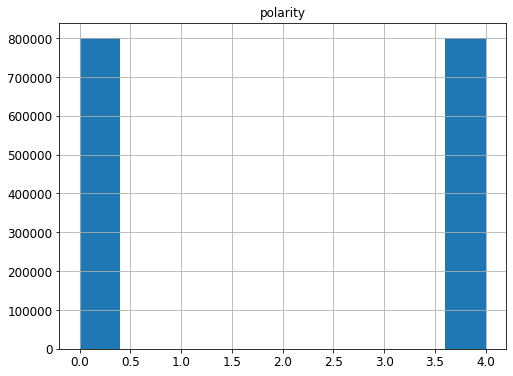

In [0]:
df.hist(["polarity"])


## Split Train and Test dataset


In [0]:
train_set, test_set = train_test_split(df[["id", "tweet", "polarity"]], test_size=0.2, random_state=20)


In [0]:
X_train = train_set.drop("polarity", axis=1) # drop labels for training set
y_train = train_set["polarity"].copy()

In [0]:
X_test = test_set.drop("polarity", axis=1) # drop labels for testing datasset
y_test = test_set["polarity"].copy()

In [0]:
# take the first num records for development purposes
NUMTRAIN = 80000
NUMTEST = 4000
X_train = X_train[:NUMTRAIN]
X_test = X_test[:NUMTEST]
y_train = y_train[:NUMTRAIN]
y_test = y_test[:NUMTEST]

In [290]:
print("X_train: " + str(X_train.shape) + str(type(X_train)))
print("X_test: "+ str(X_test.shape))
print("y_train: "+ str(y_train.shape))
print("y_test: "+ str(y_test.shape))

X_train: (80000, 2)<class 'pandas.core.frame.DataFrame'>
X_test: (4000, 2)
y_train: (80000,)
y_test: (4000,)


In [118]:
X_train.head()


,id,tweet
519968,2191957974,@iluvshinythings no wasn't me. I was wearing...
387493,2054025452,My 9 year old nephew just emailed me asking 2 ...
208291,1973686973,@jscrinc she didnt mess up
945933,1822502879,@Jennny0601 you're going to be jealous of my n...
1328534,2015529570,"@BillHarper Yes, they are - there's nothing li..."


In [119]:
print(type(y_train))
print(y_train.describe)

<class 'pandas.core.series.Series'>
<bound method NDFrame.describe of 519968     0
387493     0
208291     0
945933     4
1328534    4
          ..
38360      0
1265658    4
695488     0
581663     0
1173465    4
Name: polarity, Length: 80000, dtype: int64>


## Functions : Text-preprocessing and Lemmatize (Normalize) Tweets

In [0]:
def text_processing(tweet):
    
    # remove https links
    clean_tweet = re.sub(r'http\S+', '', tweet)
    # remove punctuation marks
    punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'
    clean_tweet = ''.join(ch for ch in clean_tweet if ch not in set(punctuation))
    # convert text to lowercase
    clean_tweet = clean_tweet.lower()
    # remove numbers
    clean_tweet = re.sub('\d', ' ', clean_tweet)
    # remove whitespaces
    clean_tweet = ' '.join(clean_tweet.split())
    return clean_tweet

In [0]:
# import the english language model from spacy'
#nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load('en')

# function to lemmatize text
def lemmatization(tweets):
    lemma_tweet = []
    for i in tweets:
        t = [token.lemma_ for token in nlp(i)]
        lemma_tweet.append(' '.join(t))
    return lemma_tweet

In [0]:
X_train['clean_tweet'] = X_train['tweet'].apply(lambda x: text_processing(x))
X_test['clean_tweet'] = X_test['tweet'].apply(lambda x: text_processing(x))

In [293]:
X_train.head()

,id,tweet,clean_tweet
519968,2191957974,@iluvshinythings no wasn't me. I was wearing...,iluvshinythings no wasn't me. i was wearing a ...
387493,2054025452,My 9 year old nephew just emailed me asking 2 ...,my year old nephew just emailed me asking join...
208291,1973686973,@jscrinc she didnt mess up,jscrinc she didnt mess up
945933,1822502879,@Jennny0601 you're going to be jealous of my n...,jennny you're going to be jealous of my new ip...
1328534,2015529570,"@BillHarper Yes, they are - there's nothing li...","billharper yes, they are there's nothing like ..."


In [294]:
# This is the cell to generate lemmatized files from the dataset
# We may also use already pre-processed files from google drive (see below)
%%time
X_train["clean_tweet"] = lemmatization(X_train["clean_tweet"])
X_test['clean_tweet'] = lemmatization(X_test['clean_tweet'])

# Expected time for 50 000 records: 3 min
# Expected time for 80 000 records: 5 min

CPU times: user 10min 31s, sys: 274 µs, total: 10min 31s
Wall time: 10min 32s


In [295]:
X_train.shape

(80000, 3)

In [296]:
X_train.head()

,id,tweet,clean_tweet
519968,2191957974,@iluvshinythings no wasn't me. I was wearing...,iluvshinything no be not -PRON- . i be wear a ...
387493,2054025452,My 9 year old nephew just emailed me asking 2 ...,-PRON- year old nephew just email -PRON- ask j...
208291,1973686973,@jscrinc she didnt mess up,jscrinc -PRON- do not mess up
945933,1822502879,@Jennny0601 you're going to be jealous of my n...,jennny -PRON- be go to be jealous of -PRON- ne...
1328534,2015529570,"@BillHarper Yes, they are - there's nothing li...","billharper yes , -PRON- be there be nothing li..."


In [297]:
X_test.head()

,id,tweet,clean_tweet
313228,2001705696,@yaeljk get to a show girl! Do whatcha gotta d...,yaeljk get to a show girl do whatcha get to do...
253601,1984029518,Ex boyfriends suck -pete! the alien-,ex boyfriend suck pete the alien
1041037,1957027349,.@SpacieStaycie which one did you like best?,.spaciestaycie which one do -PRON- like good
217422,1975936563,damn my back is hella hurtting at work,damn -PRON- back be hella hurtte at work
495067,2185120448,@tristanwilds unfortunately my days already over,tristanwild unfortunately -PRON- day already over


In [0]:
# Saved lemmatized files to Google Drive for further use
# Last time saved: 80 000 records for X_train (2019-12-13)

# Define file names and folder
X_train_lemma_file = "/content/drive/My Drive/Colab Notebooks/Final_Project/data/X_train_lemma80kNoDisabled.csv"
X_test_lemma_file = "/content/drive/My Drive/Colab Notebooks/Final_Project/data/X_test_lemma80kNoDisabled.csv"

In [0]:
# Save to files
X_train.to_csv(X_train_lemma_file, index=False)
X_test.to_csv(X_test_lemma_file, index=False)

In [0]:
# Import from files already pre-processed from Google Drive
X_train = pd.read_csv(X_train_lemma_file)
X_test = pd.read_csv(X_test_lemma_file)

In [300]:
X_train.head()

,id,tweet,clean_tweet
519968,2191957974,@iluvshinythings no wasn't me. I was wearing...,iluvshinything no be not -PRON- . i be wear a ...
387493,2054025452,My 9 year old nephew just emailed me asking 2 ...,-PRON- year old nephew just email -PRON- ask j...
208291,1973686973,@jscrinc she didnt mess up,jscrinc -PRON- do not mess up
945933,1822502879,@Jennny0601 you're going to be jealous of my n...,jennny -PRON- be go to be jealous of -PRON- ne...
1328534,2015529570,"@BillHarper Yes, they are - there's nothing li...","billharper yes , -PRON- be there be nothing li..."


In [0]:
X_train = X_train["clean_tweet"].values
X_test = X_test["clean_tweet"].values

In [302]:
print(X_train[0:5])

['iluvshinything no be not -PRON- . i be wear a pink tank top , black pant and big teal sunglass . close though ha'
 "-PRON- year old nephew just email -PRON- ask join -PRON- play mini golf , too bad i have breakfast amp meet amp greet in tyson 's so cute"
 'jscrinc -PRON- do not mess up'
 'jennny -PRON- be go to be jealous of -PRON- new iphone theme'
 'billharper yes , -PRON- be there be nothing like fresh fruit for lunch']


## Label Encoding

In [303]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)                     
y_train[:5]

array([0, 0, 0, 1, 1])

In [0]:
y_train = keras.utils.to_categorical(y_train)

In [0]:
y_test = keras.utils.to_categorical(y_test)

In [306]:
y_train[0:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [307]:
X_train.shape
# Should be (nb_of_records, )

(80000,)

# Model nnlm-en-dim128

## Create Model using tf.hub: nnlm-en-dim128

In [138]:
MODEL = "nnlm-en-dim128"
VERSION = 2
URL = "https://tfhub.dev/google/"+MODEL+"/"+str(VERSION)
print (URL)

https://tfhub.dev/google/nnlm-en-dim128/2


In [139]:
# Define the modle using Sequential api
hub_layer1 = hub.KerasLayer(URL, output_shape=[128], 
                           input_shape=[], 
                           dtype=tf.string
                          )
model = keras.Sequential()
model.add(hub_layer1)
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_10 (KerasLayer)  (None, 128)               124642688 
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 130       
Total params: 124,651,074
Trainable params: 8,386
Non-trainable params: 124,642,688
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

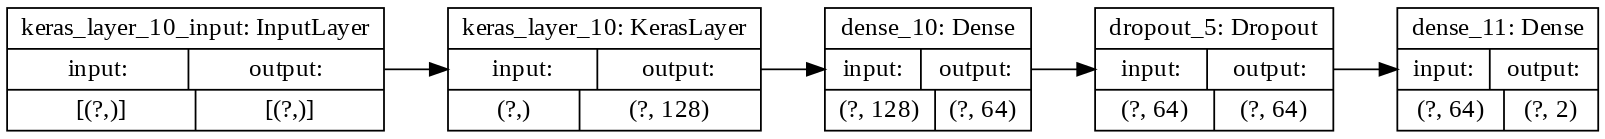

In [141]:
keras.utils.plot_model(model, 
                       #to_file='model.png',
                      show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=128)

## Execute Model

In [142]:
%%time
hist = model.fit(X_train, 
                 y_train, 
                 epochs=30,
                 batch_size=64, 
                 verbose = 1)
# Benchmark time: 2 min per 10 epochs for 50 000 records/batch 32
# Benchmark time: 6 min per 25 epochs for 80 000 records/batch 32
# Benchmark time: 1.5 min per 15 epochs for 50 000 records/batch 64
# Benchmark time: 1.5 min per 15 epochs for 80 000 records/64 nodes/batch 64
# Benchmark time: 1.5 min per 20 epochs for 80 000 records/64 nodes/batch 64
# Benchmark time: 2 min per 30 epochs for 80 000 records/64 nodes/batch 64

Train on 80000 samples
Epoch 1/30
80000/80000 [==============================] - 5s 64us/sample - loss: 0.5745 - accuracy: 0.7023
Epoch 2/30
80000/80000 [==============================] - 5s 57us/sample - loss: 0.5460 - accuracy: 0.7256
Epoch 3/30
80000/80000 [==============================] - 5s 58us/sample - loss: 0.5409 - accuracy: 0.7289
Epoch 4/30
80000/80000 [==============================] - 5s 57us/sample - loss: 0.5368 - accuracy: 0.7307
Epoch 5/30
80000/80000 [==============================] - 5s 59us/sample - loss: 0.5344 - accuracy: 0.7330
Epoch 6/30
80000/80000 [==============================] - 5s 57us/sample - loss: 0.5327 - accuracy: 0.7348
Epoch 7/30
80000/80000 [==============================] - 5s 57us/sample - loss: 0.5308 - accuracy: 0.7372
Epoch 8/30
80000/80000 [==============================] - 5s 57us/sample - loss: 0.5284 - accuracy: 0.7397
Epoch 9/30
80000/80000 [==============================] - 4s 56us/sample - loss: 0.5277 - accuracy: 0.7387
Epoch 10/30
80

<function matplotlib.pyplot.show>

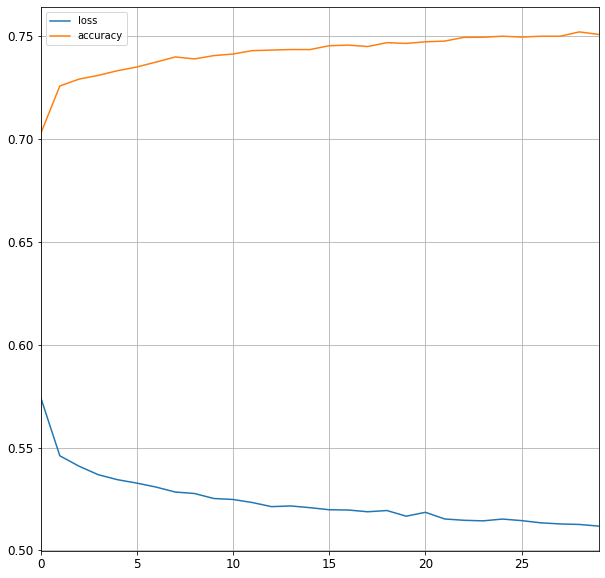

In [143]:
pd.DataFrame(hist.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

## Evaluate Model

In [144]:
accuracy_test = model.evaluate(X_test, y_test, verbose=2)
print(accuracy_test)

4000/1 - 0s - loss: 0.4721 - accuracy: 0.7545
[0.5050608222484588, 0.7545]


In [145]:
print(X_train[0:10])

['iluvshinything no be not -PRON- . i be wear a pink tank top , black pant and big teal sunglass . close though ha'
 "-PRON- year old nephew just email -PRON- ask join -PRON- play mini golf , too bad i have breakfast amp meet amp greet in tyson 's so cute"
 'jscrinc -PRON- do not mess up'
 'jennny -PRON- be go to be jealous of -PRON- new iphone theme'
 'billharper yes , -PRON- be there be nothing like fresh fruit for lunch'
 'back from church , soooooo cold outside even though -PRON- look lovely and warm , instal manga studio now'
 'youngq yesterday be ice cream day .. awww'
 'i love jamie camille antonio happy year and month'
 'iremember ... gun n rose . omg -PRON- be the shit especially slash'
 'still rain , and there be a torrent of water from the roof right outside -PRON- bedroom window sound like an elephant have a pee']


In [146]:
predictions = model.predict(X_train[:10], batch_size=None, verbose=0)
print(predictions.round(0))

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [147]:
print(y_train[:10])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


## Confusion Matrix

In [0]:
def plot_confusion_matrix(cm, 
                          classes, 
                          normalize=False,
                          title='CM', 
                          cmap=plt.cm.Greens):
# This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix") # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=45) 
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout() 
        plt.ylabel('True label') 
        plt.xlabel('Predicted label')

In [0]:
# np.argmax Returns the indices of the maximum values along an axis. 
y_test_rounded = np.argmax(y_test, axis=1)
y_train_rounded = np.argmax(y_train, axis=1)

In [0]:
y_pred = model.predict(X_train)
y_pred_rounded = np.argmax(y_pred, axis=1)

In [0]:
cmResults = confusion_matrix(y_train_rounded, y_pred_rounded) 
accuracy = accuracy_score(y_train_rounded, y_pred_rounded)

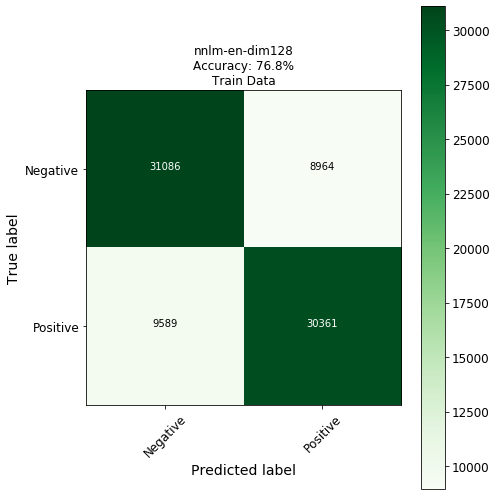

In [153]:
# Plot non-normalized confusion matrix 
class_names = ['Negative', 'Positive']
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, title=str(MODEL)+ "\n" +"Accuracy: " + str((accuracy*100).round(1)) + "%" +"\n"+"Train Data");

In [0]:
y_pred = model.predict(X_test)
y_pred_rounded = np.argmax(y_pred, axis=1)
cmResults = confusion_matrix(y_test_rounded, y_pred_rounded)
accuracy = accuracy_score(y_test_rounded, y_pred_rounded)

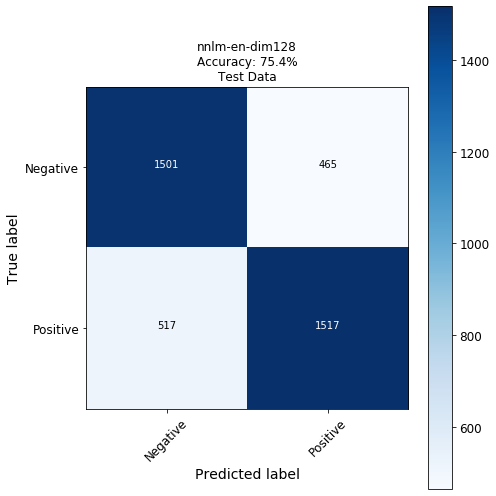

In [155]:
# Plot non-normalized confusion matrix 
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, 
                      title=str(MODEL)+ "\n" +"Accuracy: " + str((accuracy*100).round(1)) + "%" +"\n"+"Test Data",
                      cmap=plt.cm.Blues);

## Test the Model with some sentences

In [0]:
# Create input tweets for testing the sentiment model 
tweets = {'tweet':['Montreal is a nice city in the summer!!!',
                    'I have a good feeling about this team#11212',
                    'The show was not funny...',
                    'The dog is angry',
                    'The food at the restaurant could be better',
                    'The flight is a long one',
                    'It would be nice if the weather was better in Montreal *&&%&*&##!1',
                    'The Montreal hockey team will be making the playoffs',
                    'The weather in Montreal is very nice in the summer'
                   ],
          'sentiments':[4,
                       4,
                       0,
                       0,
                       0,
                       0,
                       0,
                       4,
                       4
                      ]
         } 
  
# Create DataFrame 
df_test = pd.DataFrame(tweets)

In [0]:
df_test['clean_tweet'] = df_test['tweet'].apply(lambda x: text_processing(x))

In [0]:
df_test["clean_tweet"] = lemmatization(df_test["clean_tweet"])

In [198]:
df_test

,tweet,sentiments,clean_tweet
0,Montreal is a nice city in the summer!!!,4,montreal be a nice city in the summer
1,I have a good feeling about this team#11212,4,i have a good feeling about this team
2,The show was not funny...,0,the show be not funny ...
3,The dog is angry,0,the dog be angry
4,The food at the restaurant could be better,0,the food at the restaurant could be well
5,The flight is a long one,0,the flight be a long one
6,It would be nice if the weather was better in ...,0,-PRON- would be nice if the weather be well in...
7,The Montreal hockey team will be making the pl...,4,the montreal hockey team will be make the playoff
8,The weather in Montreal is very nice in the su...,4,the weather in montreal be very nice in the su...


In [0]:
sentiments = df_test["sentiments"].copy()
label_encoder = LabelEncoder()
sentiments = label_encoder.fit_transform(sentiments)
sentiments = keras.utils.to_categorical(sentiments)

In [0]:
X_input = df_test["clean_tweet"].values

In [162]:
print(model.predict(X_input).round(0))

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [163]:
print(sentiments)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


# Model Universal Sentence Encoder



## Create Model

In [308]:
MODEL = "universal-sentence-encoder"
VERSION = 4
URL = "https://tfhub.dev/google/"+MODEL+"/"+str(VERSION)
print (URL)

https://tfhub.dev/google/universal-sentence-encoder/4


In [309]:
hub_layer2 = hub.KerasLayer(URL, 
                           output_shape=[512], 
                           input_shape=[], 
                           dtype=tf.string
                          )
model = keras.Sequential()
model.add(hub_layer2)
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_12 (KerasLayer)  (None, 512)               256797824 
_________________________________________________________________
dense_14 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 130       
Total params: 256,830,786
Trainable params: 32,962
Non-trainable params: 256,797,824
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

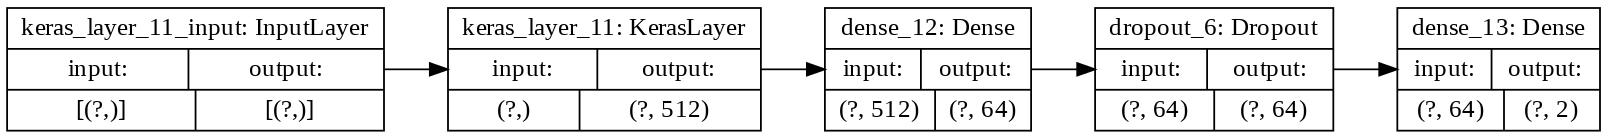

In [167]:
keras.utils.plot_model(model, 
                       #to_file='model.png',
                       show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=128)

## Execute Model

In [311]:
%%time
hist = model.fit(X_train, 
                 y_train, 
                 epochs=30, 
                 batch_size=64, 
                 verbose = 1)
# Benchmark time: 21 min for 25 epochs/80 000 records/32 nodes/batch 32
# Benchmark time: 10 min for 12 epochs/80 000 records/32 nodes/batch 32
# Benchmark time: 6 min for 20 epochs/50 000 records/64 nodes/batch 64
# Benchmark time: 10 min for 30 epochs/80 000 records/64 nodes/batch 64

Train on 80000 samples
Epoch 1/30
80000/80000 [==============================] - 16s 197us/sample - loss: 0.5153 - accuracy: 0.7472
Epoch 2/30
80000/80000 [==============================] - 15s 182us/sample - loss: 0.4921 - accuracy: 0.7623
Epoch 3/30
80000/80000 [==============================] - 15s 181us/sample - loss: 0.4865 - accuracy: 0.7657
Epoch 4/30
80000/80000 [==============================] - 15s 182us/sample - loss: 0.4815 - accuracy: 0.7689
Epoch 5/30
80000/80000 [==============================] - 15s 183us/sample - loss: 0.4782 - accuracy: 0.7704
Epoch 6/30
80000/80000 [==============================] - 15s 185us/sample - loss: 0.4752 - accuracy: 0.7734
Epoch 7/30
80000/80000 [==============================] - 15s 183us/sample - loss: 0.4719 - accuracy: 0.7763
Epoch 8/30
80000/80000 [==============================] - 14s 180us/sample - loss: 0.4705 - accuracy: 0.7779
Epoch 9/30
80000/80000 [==============================] - 15s 187us/sample - loss: 0.4663 - accuracy: 0.7

<function matplotlib.pyplot.show>

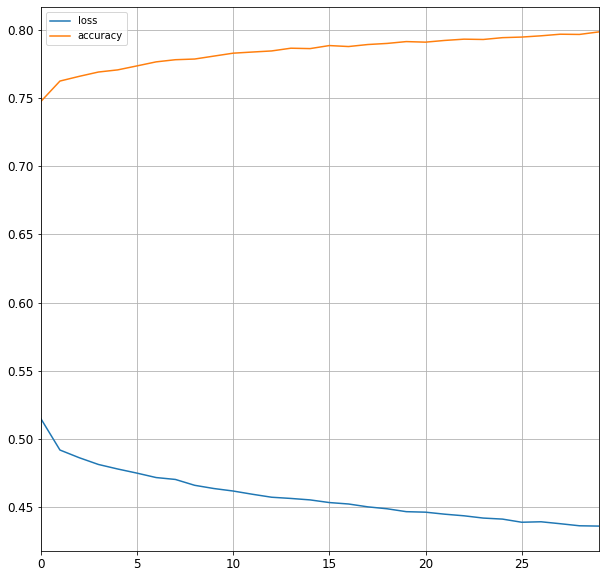

In [328]:
pd.DataFrame(hist.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

## Evaluate Model Universal Sentence Encoder

In [329]:
accuracy_test = model.evaluate(X_test, y_test, verbose=2)
print(accuracy_test)

4000/1 - 1s - loss: 0.3646 - accuracy: 0.7845
[0.4594993982315064, 0.7845]


In [330]:
print(X_train[0:10])

['iluvshinything no be not -PRON- . i be wear a pink tank top , black pant and big teal sunglass . close though ha'
 "-PRON- year old nephew just email -PRON- ask join -PRON- play mini golf , too bad i have breakfast amp meet amp greet in tyson 's so cute"
 'jscrinc -PRON- do not mess up'
 'jennny -PRON- be go to be jealous of -PRON- new iphone theme'
 'billharper yes , -PRON- be there be nothing like fresh fruit for lunch'
 'back from church , soooooo cold outside even though -PRON- look lovely and warm , instal manga studio now'
 'youngq yesterday be ice cream day .. awww'
 'i love jamie camille antonio happy year and month'
 'iremember ... gun n rose . omg -PRON- be the shit especially slash'
 'still rain , and there be a torrent of water from the roof right outside -PRON- bedroom window sound like an elephant have a pee']


In [331]:
predictions = model.predict(X_train[:10], batch_size=None, verbose=0)
print(predictions.round(0))

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [332]:
y_train[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

## Confusion Matrix

In [0]:
# np.argmax Returns the indices of the maximum values along an axis. 
y_test_rounded = np.argmax(y_test, axis=1)
y_train_rounded = np.argmax(y_train, axis=1)

In [0]:
y_pred = model.predict(X_train)
y_pred_rounded = np.argmax(y_pred, axis=1)

In [0]:
cmResults = confusion_matrix(y_train_rounded, y_pred_rounded)
accuracy = accuracy_score(y_train_rounded, y_pred_rounded)

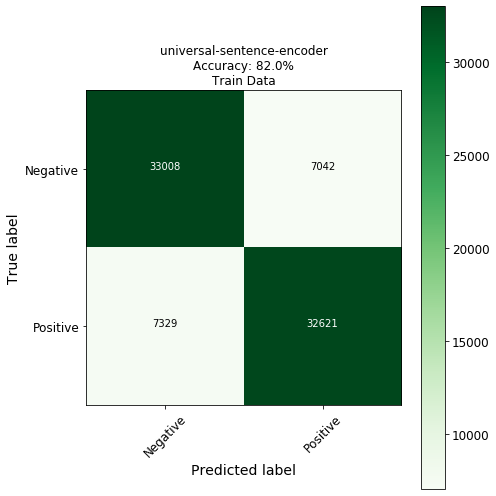

In [337]:
# Plot non-normalized confusion matrix 
class_names = ['Negative', 'Positive']
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, 
                      title=str(MODEL)+ "\n" +"Accuracy: " + str((accuracy*100).round(1)) + "%" +"\n"+"Train Data",
                      cmap=plt.cm.Greens);

In [0]:
y_pred = model.predict(X_test)
y_pred_rounded = np.argmax(y_pred, axis=1)
cmResults = confusion_matrix(y_test_rounded, y_pred_rounded)
accuracy = accuracy_score(y_test_rounded, y_pred_rounded)

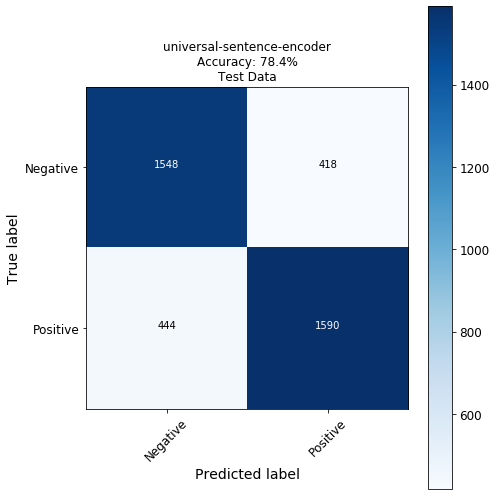

In [339]:
# Plot non-normalized confusion matrix 
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, 
                      title=str(MODEL)+ "\n" +"Accuracy: " + str((accuracy*100).round(1)) + "%" +"\n"+"Test Data",
                      cmap=plt.cm.Blues);

## Test the Model with some sentences

In [323]:
X_input

array(['montreal be a nice city in the summer',
       'i have a good feeling about this team',
       'the show be not funny ...', 'the dog be angry',
       'the food at the restaurant could be well',
       'the flight be a long one',
       '-PRON- would be nice if the weather be well in montreal',
       'the montreal hockey team will be make the playoff',
       'the weather in montreal be very nice in the summer'], dtype=object)

In [324]:
print(model.predict(X_input).round(0))

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [326]:
model.predict(["It would be fun if the weather was nicer"])

array([[0.34651932, 0.6534807 ]], dtype=float32)

In [327]:
print(sentiments)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


# Execute Model without Text Preprocessing

In [0]:
X_train = train_set.drop("polarity", axis=1) # drop labels for training set
y_train = train_set["polarity"].copy()

In [0]:
X_test = test_set.drop("polarity", axis=1) # drop labels for testing datasset
y_test = test_set["polarity"].copy()

In [0]:
# take the first num records for development purposes
NUMTRAIN = 80000
NUMTEST = 4000
X_train = X_train[:NUMTRAIN]
X_test = X_test[:NUMTEST]
y_train = y_train[:NUMTRAIN]
y_test = y_test[:NUMTEST]

In [266]:
print("X_train: " + str(X_train.shape) + str(type(X_train)))
print("X_test: "+ str(X_test.shape))

X_train: (80000, 2)<class 'pandas.core.frame.DataFrame'>
X_test: (4000, 2)


In [0]:
X_train['clean_tweet'] = X_train['tweet']
X_test['clean_tweet'] = X_test['tweet']

In [268]:
X_train.head()

,id,tweet,clean_tweet
519968,2191957974,@iluvshinythings no wasn't me. I was wearing...,@iluvshinythings no wasn't me. I was wearing...
387493,2054025452,My 9 year old nephew just emailed me asking 2 ...,My 9 year old nephew just emailed me asking 2 ...
208291,1973686973,@jscrinc she didnt mess up,@jscrinc she didnt mess up
945933,1822502879,@Jennny0601 you're going to be jealous of my n...,@Jennny0601 you're going to be jealous of my n...
1328534,2015529570,"@BillHarper Yes, they are - there's nothing li...","@BillHarper Yes, they are - there's nothing li..."


In [0]:
X_train = X_train["clean_tweet"].values
X_test = X_test["clean_tweet"].values

In [270]:
X_train.shape

(80000,)

In [271]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)                     
y_train[:5]

array([0, 0, 0, 1, 1])

In [0]:
y_train = keras.utils.to_categorical(y_train)

In [0]:
y_test = keras.utils.to_categorical(y_test)

In [274]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [275]:
%%time
hist = model.fit(X_train, 
                 y_train, 
                 epochs=30, 
                 batch_size=64, 
                 verbose = 1)
# Benchmark time: 8 min for 30 epochs/80 000 records/64 nodes/batch 64

Train on 80000 samples
Epoch 1/30
80000/80000 [==============================] - 15s 184us/sample - loss: 0.4475 - accuracy: 0.7908
Epoch 2/30
80000/80000 [==============================] - 15s 184us/sample - loss: 0.4386 - accuracy: 0.7966
Epoch 3/30
80000/80000 [==============================] - 15s 186us/sample - loss: 0.4341 - accuracy: 0.7986
Epoch 4/30
80000/80000 [==============================] - 15s 183us/sample - loss: 0.4310 - accuracy: 0.8005
Epoch 5/30
80000/80000 [==============================] - 15s 182us/sample - loss: 0.4266 - accuracy: 0.8022
Epoch 6/30
80000/80000 [==============================] - 15s 182us/sample - loss: 0.4249 - accuracy: 0.8032
Epoch 7/30
80000/80000 [==============================] - 15s 183us/sample - loss: 0.4238 - accuracy: 0.8038
Epoch 8/30
80000/80000 [==============================] - 15s 181us/sample - loss: 0.4216 - accuracy: 0.8048
Epoch 9/30
80000/80000 [==============================] - 15s 185us/sample - loss: 0.4196 - accuracy: 0.8

In [276]:
accuracy_test = model.evaluate(X_test, y_test, verbose=2)
print(accuracy_test)

4000/1 - 1s - loss: 0.3558 - accuracy: 0.8048
[0.4372045520544052, 0.80475]


In [277]:
print(model.predict(X_input).round(0))

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [285]:
model.predict(["It would be bad if the drink be not good"])

array([[0.71672434, 0.28327566]], dtype=float32)

In [279]:
print(sentiments)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


# Save Keras Model

In [204]:
# save model and architecture to single file
model_version = "0001"
model_name = "JP_sentiment_analysis_service"
model_path = os.path.join(model_name, model_version)
tf.saved_model.save(model, model_path)
print("Saved model to disk")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: JP_sentiment_analysis_service/0001/assets


INFO:tensorflow:Assets written to: JP_sentiment_analysis_service/0001/assets


Saved model to disk


In [205]:
!saved_model_cli show --dir {model_path}

The given SavedModel contains the following tag-sets:
serve


In [206]:
!saved_model_cli show --dir {model_path} --tag_set serve

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


In [207]:
!saved_model_cli show --dir {model_path} --tag_set serve \
                      --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_11_input'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_keras_layer_11_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_13'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall_1:0
Method name is: tensorflow/serving/predict


In [208]:
!saved_model_cli show --dir {model_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['keras_layer_11_input'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: serving_default_keras_layer_11_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_13'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 2)
        name: StatefulPartitionedCall_1:0
  Method name is: tensorflow/serving/predict


# Copy Model to Google Storage (Bucket)

In [0]:
import sys

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''

In [210]:
PROJECT_ID = "utopian-rush-255612" #@param {type:"string"}

# This must absolutely be a GLOBALLY UNIQUE name
BUCKET_NAME = "utopian-rush-255612-bucket_ml2" #@param {type:"string"}
REGION = "us-east1" #@param {type:"string"}

! gcloud config set project $PROJECT_ID
! echo $PROJECT_ID

Updated property [core/project].
utopian-rush-255612


In [211]:
# Create Bucket

! gsutil mb -p $PROJECT_ID -l $REGION gs://$BUCKET_NAME
# Display what is in the bucket
!gsutil ls -al gs://$BUCKET_NAME

Creating gs://utopian-rush-255612-bucket_ml2/...


In [0]:
JOB_DIR = 'gs://' + BUCKET_NAME + '/my_sentiment_analysis_model'

In [213]:
# Export the model to a local SavedModel directory 
# export_path = tf.contrib.saved_model.save_keras_model(model, 'keras_export')
# print("Model exported to: ", export_path)

# Export the model to a SavedModel directory in Cloud Storage
export_path = tf.saved_model.save(model, JOB_DIR + '/0001')
print("Model exported to: ", export_path)

INFO:tensorflow:Assets written to: gs://utopian-rush-255612-bucket_ml2/my_sentiment_analysis_model/0001/assets


INFO:tensorflow:Assets written to: gs://utopian-rush-255612-bucket_ml2/my_sentiment_analysis_model/0001/assets


Model exported to:  None


# Create the Model in the AI Platform

In [214]:
MODEL_NAME = "sa_final_project"

! gcloud ai-platform models create $MODEL_NAME --regions $REGION

Created ml engine model [projects/utopian-rush-255612/models/sa_final_project].


# Create the Version of the Model in AI Platform

In [215]:
! gcloud ai-platform versions create v1 \
  --model $MODEL_NAME \
  --runtime-version 1.14 \
  --python-version 3.5 \
  --framework tensorflow \
  --origin gs://utopian-rush-255612-bucket_ml2/my_sentiment_analysis_model/0001/

ERROR: (gcloud.ai-platform.versions.create) FAILED_PRECONDITION: Field: version.deployment_uri Error: The total size of files in gs://utopian-rush-255612-bucket_ml2/my_sentiment_analysis_model/0001/ is 1036419276 bytes, which exceeds the allowed maximum of 524288000 bytes.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: The total size of files in gs://utopian-rush-255612-bucket_ml2/my_sentiment_analysis_model/0001/
      is 1036419276 bytes, which exceeds the allowed maximum of 524288000 bytes.
    field: version.deployment_uri
